In [22]:
# load the saved parameters and do visualization for W, a and C_alpha.
import numpy as np
import matplotlib.pyplot as plt


colors = plt.get_cmap('Set2').colors


train_method = 'CWa'

path = f'/data3/wangshaobo/ICL/RPE/results_paper/NGram/CWa_parent2_n10000_L100_S3_H3_1.0_optsgd_w+3.0_w-0.1_D2_c_alpha_init0.01_a_init0.01_alpha0.1_n-epochs[50000].npz'
data = np.load(path)

# extract info from path, about L, S, H
path = path.split('/')[-1]
path = path.split('_')
if train_method == 'C_W_a':
    L = int(path[5][1:])
    S = int(path[6][1:])
    H = int(path[7][1:])
    D = path[14][1:]
elif train_method == 'CW_a':
    L = int(path[4][1:])
    S = int(path[5][1:])
    H = int(path[6][1:])
    D = path[13][1:]
elif train_method == 'CWa':
    L = int(path[3][1:])
    S = int(path[4][1:])
    H = int(path[5][1:])
    D = path[10][1:]
print('L, S, H, D', L, S, H, D)



L, S, H, D 100 3 3 2


In [23]:
# check the dict of data saved with npz
print(data.files)
alphas = data['alphas']
alphas = [alpha[1:] for alpha in alphas]

['W_before', 'train_loss_list_1', 'val_loss_list_1', 'W_after', 'C_list', 'a_list', 'alphas']


(50001, 7)


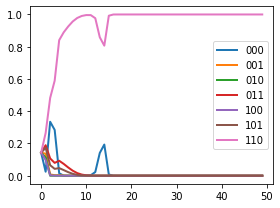

In [24]:
# plot C_list curve, C_list is a list of multiple C_alpha, draw the curve of each alpha.
# each alpha is corrensding to a binary coding of H+1 positions, change alpha to binary, then to a list of 0 and 1.
C_list = data['C_list']
# plot the ratio of each C_alpha **2 over the some of all C_alpha**2
C_list_squre = C_list**2
C_list_squre = C_list_squre / np.sum(C_list_squre, axis = 1)[:,np.newaxis]
print(C_list_squre.shape)
keep = 50
plt.figure(figsize=(4,3))
for i in range(len(alphas)):
    plt.plot(C_list_squre[:keep,i], label = alphas[i], linewidth=2)
    plt.legend()
# plt.xlabel('epoch')
# plt.ylabel(r'$c_\mathcal{S}$')
plt.tight_layout()
plt.savefig(f'figures/{train_method}_{D}_C_alpha.svg')


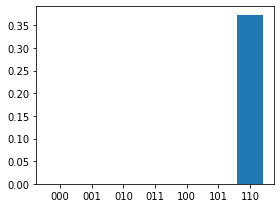

In [25]:
C_alpha_value = C_list[-1]
# draw the C_alpha_value bar plot
plt.figure(figsize=(4,3))
plt.bar(range(len(C_alpha_value)), C_alpha_value)
# plt.xlabel(r'$\alpha$')
# plt.ylabel(r'$c_\mathcal{S}$')
plt.xticks(range(len(C_alpha_value)), alphas)
plt.tight_layout()
plt.savefig(f'figures/{train_method}_{D}_C_alpha_bar.svg')


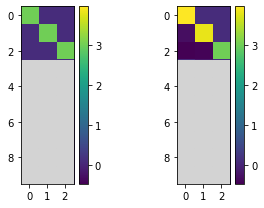

In [26]:
# draw W_before and W_after heatmap
W_before = data['W_before'][0][:10,:10]
W_after = data['W_after'][0][:10,:10]
# Get the min and max values for normalization
vmin = min(W_before.min(), W_after.min())
vmax = max(W_before.max(), W_after.max())
default_color = 'lightgray'  # Define a color for the other entries

# Create the figure and subplots
plt.figure(figsize=(4, 3))

# Plot W_before
plt.subplot(1, 2, 1)
plt.imshow(W_before, aspect='equal', vmin=vmin, vmax=vmax)
for i in range(H, W_before.shape[0]):
    for j in range(0, W_before.shape[1]):
        plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color=default_color))
plt.xticks([0,1,2])
plt.colorbar()

# Plot W_after
plt.subplot(1, 2, 2)
plt.imshow(W_after, aspect='equal', vmin=vmin, vmax=vmax)
for i in range(H, W_after.shape[0]):
    for j in range(0, W_after.shape[1]):
        plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color=default_color))
plt.xticks([0,1,2])
plt.colorbar()
plt.tight_layout()
# make two subplot near
plt.subplots_adjust(wspace=0.5)
plt.savefig(f'figures/{train_method}_{D}_W_before_after.svg')


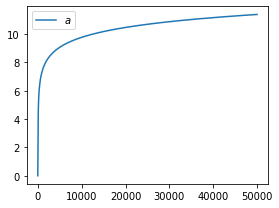

In [27]:
# plot a_list curve
a_list = data['a_list']
plt.figure(figsize=(4,3))
plt.plot(a_list,label=r'$a$')
plt.legend()
# plt.xlabel('epoch')
plt.tight_layout()
plt.savefig(f'figures/{train_method}_{D}_a.svg')


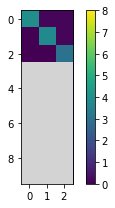

In [28]:
# draw W_before and W_after heatmap
W_after = data['W_after'][0][:10,:10]
# Get the min and max values for normalization
vmin = 0
vmax = 8
# Create the figure and subplots
plt.figure(figsize=(4, 3))

plt.imshow(W_after, aspect='equal', vmin=vmin, vmax=vmax)
for i in range(H, W_after.shape[0]):
    for j in range(0, W_after.shape[1]):
        plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color=default_color))
plt.colorbar()
plt.tight_layout()
plt.xticks([0,1,2])
# make two subplot near
plt.subplots_adjust(wspace=0.5)
plt.savefig(f'figures/{train_method}_{D}_W_after.svg')


In [29]:
import torch
def create_matrix_W_h(W, H, L, h):
    """
    Create and return the softmax-normalized matrix W_h based on the input numpy matrix W_np.
    
    Args:
    W_np (numpy.ndarray): Input numpy array of shape [S, T], where each column represents values for the diagonals of W_h.
    T (int): The size of the desired output matrix W_h, which will be (T+1) x (T+1).
    
    Returns:
    numpy.ndarray: Output matrix W_h after applying softmax, of shape [T+1, T+1].
    """
    # Convert numpy matrix to torch.Tensor
    W = torch.tensor(W, dtype=torch.float32)
    
    W_h = torch.full((L+1, L+1), float('-inf'), dtype=torch.float32, device=W.device)
    # Fill the diagonals
    for j in range(H):
        torch.diagonal(W_h, -j-1-h).fill_(W[j+h])
    W_h_np = W_h.detach().cpu().numpy()
    return W_h_np




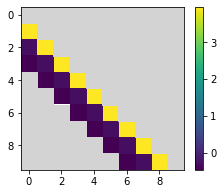

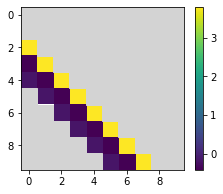

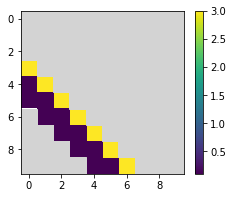

In [30]:
# draw W_h, make the -inf value to default value
default_color = 'lightgray'  # Define a color for the other entries


# plot W_h
# head 1
for h in range(H):
    W_h = data['W_after'][0][:, h]
    W_h = create_matrix_W_h(W_h, H, L, h)[:10,:10]
    plt.figure(figsize=(4, 3))
    plt.imshow(W_h, aspect='equal')

    # add gray color  patches rect for -inf value
    for i in range(W_h.shape[0]):
        for j in range(W_h.shape[1]):
            if W_h[i, j] == float('-inf'):
                plt.gca().add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color=default_color))

    plt.colorbar()
    plt.savefig(f'figures/{train_method}_{D}_W_{h}.svg')


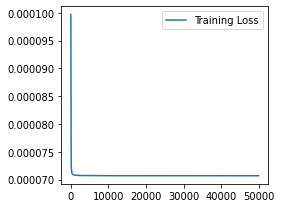

In [31]:
# plot the train_loss_list and val_loss_list
train_loss_list = data['train_loss_list_1']
val_loss_list = data['train_loss_list_1']
plt.figure(figsize=(4,3))
plt.plot(train_loss_list,label='Training Loss')
# plt.plot(val_loss_list,label='val_loss')
# add phase change line
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/{train_method}_{D}_loss.svg')